# April 30, 2024: aggregate SBMs using peak partitions of session wise modes

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 

from scipy import sparse, stats
import glob
from tqdm import tqdm
import ants
from nipype.interfaces import afni
from itertools import product, combinations

import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

240603-23:52:20,309 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.6.1


In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

def set_seed(args):
    gt.seed_rng(args.SEED)
    np.random.seed(args.SEED)

set_seed(args)

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 15 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = f'{BASE_path}/roi_results'
ROI_RESULTS_path = f'{ROI_path}/{DESC}/{args.unit}/density-{args.denst}'
FC_path = f'{ROI_RESULTS_path}/corr_mats'
SBM_path = f'{ROI_RESULTS_path}/sbms'
NPY_path = f'{ROI_RESULTS_path}/npy'
os.system(f'mkdir -p {NPY_path}')
NII_path = f'{ROI_RESULTS_path}/niis'
os.system(f'mkdir -p {NII_path}/indiv')
os.system(f'mkdir -p {NII_path}/group')

# sbm model class
args.dc = ''
args.sbm = 'a' 

In [4]:
parcels_img = ants.image_read(f'{PARCELS_path}/{DESC}_desc-parcels.nii.gz')
parcels = parcels_img.numpy()
roi_labels = np.loadtxt(f'{PARCELS_path}/{DESC}_desc-labels.txt')

In [5]:
def collect_indiv_sbm_fits(args, files):
    def get(name):
        l = [s for s in ssr if name in s]
        return l[0].split('-')[-1] if len(l) > 0 else '0'
    
    fits_df = []
    for file in tqdm(files):
        ssr = file.split('/')[-2].split('_')
        sub, ses, run = list(map(get, ['sub', 'ses', 'run']))
        try:
            with open(f'{file}', 'rb') as f:
                all_vars = pickle.load(f)
                if len(all_vars) == 7:
                    [g, L, pmode, modes, marginals, state, Bes] = all_vars
                    converged = False
                elif len(all_vars) == 8:
                    [g, L, pmode, modes, marginals, state, Bes, converged] = all_vars
            
            df = pd.DataFrame({
                'sub':[int(sub[-2:])],
                'ses':[int(ses)],
                'run':[int(run)],
                'ssr':[ssr],
                'graph':[g],
                'sbm':[f'sbm-{args.dc}-{args.sbm}'],
                'evidence':[L],
                'state':[state],
                'pmode':[pmode],
                'modes':[modes],
                'num_modes':[len(modes)],
                'marginals':[marginals],
                'Be':[Bes],
                'converged':[converged],
                'file':[file],
            })
            
            fits_df.append(df)
        except:
            pass
    fits_df = pd.concat(fits_df)
    fits_df = fits_df.sort_values(
        by=['sub', 'ses', 'run']
    ).reset_index(drop=True)

    return fits_df

In [6]:
def collect_nested_partitions(args, fits_df):
    dfs = []
    for idx, row in tqdm(fits_df.iterrows()):
        sub, ses, run = row[['sub', 'ses', 'run']]
        modes = row['modes']
        # M = len(row['bs'])

        for idx_mode, mode in enumerate(modes):
            bs = mode.get_max_nested()
            
            df = pd.DataFrame({
                'sub':[sub],
                'ses':[ses],
                'run':[run],
                'mode':[idx_mode],
                'b':[bs],
            })
            dfs.append(df)
    dfs = pd.concat(dfs).reset_index(drop=True)

    set_seed(args)
    pmode = gt.ModeClusterState(dfs['b'].to_list(), nested=True)
    pmode.relabel(maxiter=100000)
    gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
    return dfs, pmode

def collect_partitions(args, fits_df):
    dfs = []
    for idx, row in tqdm(fits_df.iterrows()):
        sub, ses, run = row[['sub', 'ses', 'run']]
        g = row['graph']
        modes = row['modes']
        M = len(row['pmode'].__getstate__()['bs'])

        for idx_mode, mode in enumerate(modes):
            b = list(mode.get_max(g))

            df = pd.DataFrame({
                'sub':[sub],
                'ses':[ses],
                'run':[run],
                'mode':[idx_mode],
                'b':[b],
            })
            dfs.append(df)
    dfs = pd.concat(dfs).reset_index(drop=True)

    set_seed(args)
    pmode = gt.ModeClusterState(dfs['b'].to_list())
    pmode.relabel(maxiter=100000)
    gt.mcmc_equilibrate(pmode, wait=1, mcmc_args=dict(niter=1, beta=np.inf))
    return dfs, pmode

In [7]:
def nested_partitions(b, state):
    state = state.copy(bs=b)
    bs = []
    for l, bl in enumerate(b):
        bl_ = np.array(state.project_level(l).get_state().a)
        bs.append(bl_)
        if len(np.unique(bl_)) == 1: break
    return bs

def group_nested_modes(args, pmode):
    mode_df = []
    M = len(pmode.bs)
    for idx_mode, mode in enumerate(pmode.get_modes()):
        omega = mode.get_M() / M
        sigma = mode.posterior_cdev()
        try: ratio = omega/sigma
        except: ratio = 0.0
        df = pd.DataFrame({
            'mode_id':[idx_mode],
            'mode':[mode],
            'omega':[omega],
            'sigma':[sigma],
            'ratio':[ratio],
            'b':[mode.get_max_nested()],
        })
        mode_df.append(df)
    mode_df = pd.concat(mode_df).reset_index(drop=True)
    
    # realign the final mode-partitions to ensure they align
    # and also align them for ease of visualization
    bs = mode_df['b'].to_list()
    group_pmode = gt.ModeClusterState(bs=bs, nested=True)
    mode_df['b'] = group_pmode.bs
    
    for idx, row in mode_df.iterrows():
        bs = row['b']
        bs = gt.nested_partition_clear_null(bs)
        state = gt.NestedBlockState(g, bs=[g.new_vp("int", vals=bs[0])] + bs[1:])
        row['b'] = nested_partitions(bs, state)
        mode_df.iloc[idx] = row
    
    return mode_df


def group_modes(args, pmode):
    mode_df = []
    M = len(pmode.bs)
    for idx_mode, mode in enumerate(pmode.get_modes()):
        omega = mode.get_M() / M
        sigma = mode.posterior_cdev()
        try: ratio = omega/sigma
        except: ratio = 0.0
        df = pd.DataFrame({
            'mode_id':[idx_mode],
            'mode':[mode],
            'omega':[omega],
            'sigma':[sigma],
            'ratio':[ratio],
            'b':[list(mode.get_max(g))],
        })
        mode_df.append(df)
    mode_df = pd.concat(mode_df).reset_index(drop=True)
    
    # realign the final mode-partitions to ensure they align
    # and also align them for ease of visualization
    group_pmode = gt.ModeClusterState(mode_df['b'].to_list())
    mode_df['b'] = [list(b[0]) for b in group_pmode.bs]
    return mode_df

In [8]:
from pathlib import Path
if Path(f'{NPY_path}/sbm-{args.dc}-{args.sbm}_desc-group-modes.npy').is_file():
    with open(f'{NPY_path}/sbm-{args.dc}-{args.sbm}_desc-group-modes.npy', 'rb') as f:
        [dfs, mode_df] = pickle.load(f)
else:
    files = sorted(glob.glob(f'{SBM_path}/*/sbm-{args.dc}-{args.sbm}*'))
    fits_df = collect_indiv_sbm_fits(args, files)
    display(fits_df[fits_df['sub'] == 2])
    
    set_seed(args)
    g = fits_df.iloc[0]['graph']
    state = fits_df.iloc[0]['state']
    if args.sbm in ['h']:
        dfs, pmode = collect_nested_partitions(args, fits_df)
        mode_df = group_nested_modes(args, pmode)
    elif args.sbm in ['a', 'd']:
        dfs, pmode = collect_partitions(args, fits_df)
        mode_df = group_modes(args, pmode)
    
    with open(f'{NPY_path}/sbm-{args.dc}-{args.sbm}_desc-group-modes.npy', 'wb') as f:
        pickle.dump([dfs, mode_df], f)

mode_df

100%|██████████| 25/25 [03:06<00:00,  7.45s/it]


,sub,ses,run,ssr,graph,sbm,evidence,state,pmode,modes,num_modes,marginals,Be,converged,file
2,2,1,0,"[sub-SLC02, ses-1]","<Graph object, undirected, with 162 vertices a...",sbm--a,-4689.924393,"<PPBlockState object with 4 blocks, for graph ...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,5,"[[[1.0, 0.0, 0.0, 0.0], [0.994, 0.006, 0.0, 0....","[3.515932658794074, 3.505069774201053, 3.47977...",False,/home/govindas/mouse_dataset/roi_results/type-...
3,2,2,0,"[sub-SLC02, ses-2]","<Graph object, undirected, with 162 vertices a...",sbm--a,-4886.229046,"<PPBlockState object with 11 blocks, for graph...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,16,"[[[0.253, 0.042, 0.182, 0.131, 0.125, 0.146, 0...","[6.927214464631235, 6.99585716705244, 6.995165...",False,/home/govindas/mouse_dataset/roi_results/type-...
4,2,3,0,"[sub-SLC02, ses-3]","<Graph object, undirected, with 162 vertices a...",sbm--a,-4904.279421,"<PPBlockState object with 6 blocks, for graph ...",<graph_tool.inference.partition_modes.ModeClus...,[<graph_tool.inference.partition_modes.Partiti...,10,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.546,...","[4.55520145336153, 4.414661612188175, 4.420273...",False,/home/govindas/mouse_dataset/roi_results/type-...


25it [00:00, 367.92it/s]


,mode_id,mode,omega,sigma,ratio,b
0,0,<graph_tool.inference.partition_modes.Partitio...,0.810345,0.307723,2.633361,"[0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, ..."
1,1,<graph_tool.inference.partition_modes.Partitio...,0.103448,0.112140,0.922493,"[0, 1, 6, 3, 0, 0, 1, 0, 1, 1, 0, 5, 0, 0, 0, ..."
2,2,<graph_tool.inference.partition_modes.Partitio...,0.045977,0.100309,0.458355,"[0, 5, 5, 3, 7, 2, 5, 0, 5, 5, 1, 5, 1, 0, 2, ..."
3,3,<graph_tool.inference.partition_modes.Partitio...,0.040230,0.064374,0.624941,"[0, 1, 1, 0, 4, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ..."


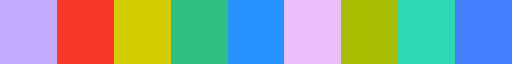

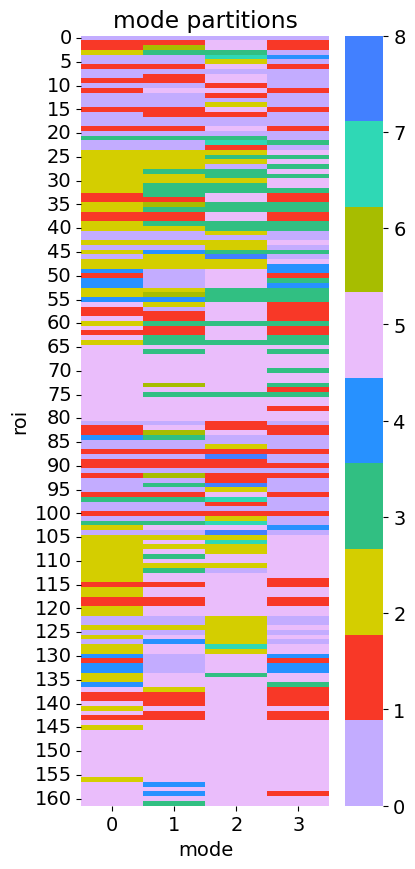

In [9]:
# perceptually uniform custom colormap
import colorcet as cc
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
def get_uniform_colors():
    colors_val = []
    for idx in np.arange(5, 56, 10):
        colors_val += cc.CET_C6s[idx:256:55]
    colors_val.pop(6)
    colors_rgb = [colors.to_rgb(c) for c in colors_val]
    return colors_val, colors_rgb

def visualize_nested_modes(args, mode_df, level, colors_val, colors_rgb):
    bs = np.stack([bs[level] for bs in mode_df['b'].to_list()]).T
    max_num_colors = np.max(bs)+1
    colors_val = colors_val[:max_num_colors]
    colors_rgb = colors_rgb[:max_num_colors]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors_rgb, N=len(colors_rgb))
    display(cmap)
    
    fig, axs = plt.subplots(1, 1, figsize=(4, 10))
    ax = axs
    sns.heatmap(bs, ax=ax, cmap=cmap)
    ax.set(title=f'mode partitions, level {level}', ylabel=f'roi', xlabel=f'mode')
    return None

def visualize_modes(args, mode_df, colors_val, colors_rgb):
    bs = np.stack(mode_df['b'].to_list()).T
    max_num_colors = np.max(bs)+1
    colors_val = colors_val[:max_num_colors]
    colors_rgb = colors_rgb[:max_num_colors]
    cmap = LinearSegmentedColormap.from_list('custom_cmap', colors_rgb, N=len(colors_rgb))
    display(cmap)

    fig, axs = plt.subplots(1, 1, figsize=(4, 10))
    ax = axs
    sns.heatmap(bs, ax=ax, cmap=cmap)
    ax.set(title=f'mode partitions', ylabel=f'roi', xlabel=f'mode')
    return None

    
colors_val, colors_rgb = get_uniform_colors()
if args.sbm in ['h']:
    for level in range(3):
        visualize_nested_modes(args, mode_df, level, colors_val, colors_rgb)
if args.sbm in ['a', 'd']:
    visualize_modes(args, mode_df, colors_val, colors_rgb)

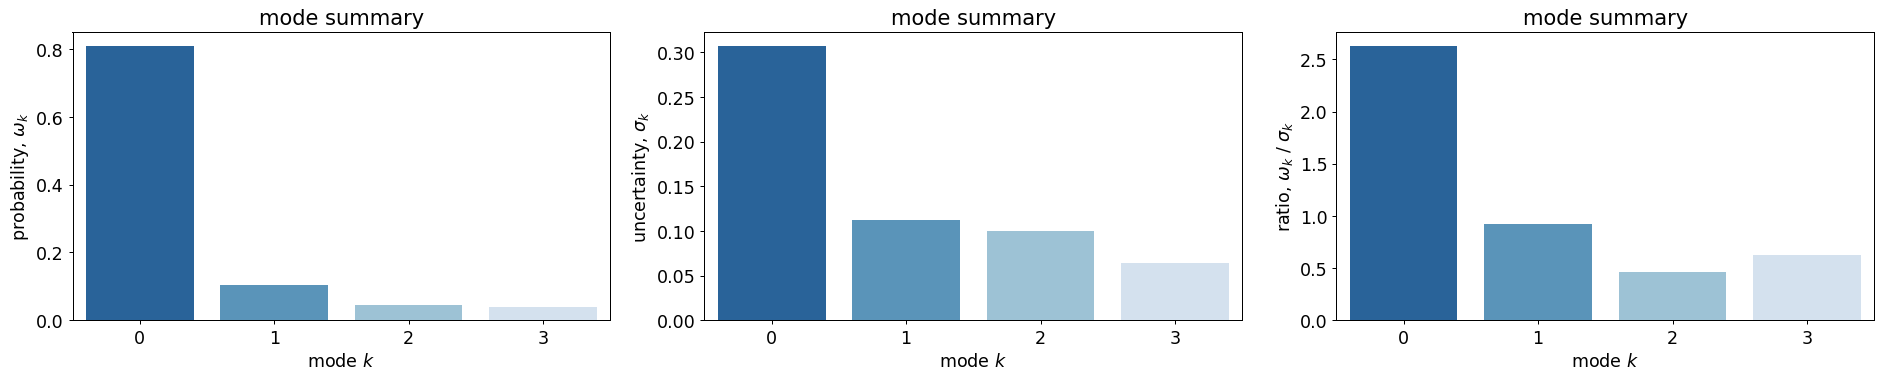

In [10]:
ncols = 3
nrows = 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols, 4*nrows), dpi=90, sharex=False, sharey=False)
fig.tight_layout(h_pad=3, w_pad=2.5)

ylabels = ['probability, $\omega_k$', 'uncertainty, $\sigma_k$', 'ratio, $\omega_k$ / $\sigma_k$']
for idx, col in enumerate(mode_df.columns[2:5]):
    ax = axs[idx]
    
    sns.barplot(data=mode_df, x=mode_df.index, y=col, ax=ax, palette='Blues_r')
    ax.set(title='mode summary', ylabel=ylabels[idx], xlabel='mode $k$')

In [11]:
def group_partition_to_nifti(args, idx_mode, x, omega, sigma, ratio):
    parcels = parcels_img.numpy()
    x_img = np.zeros_like(parcels)
    for idx, roi in enumerate(roi_labels):
        x_img += (parcels == roi) * (x[idx]+1)
    
    parcels_img.new_image_like(x_img).to_filename(
        f'{NII_path}/group/sbm-{args.dc}-{args.sbm}_mode-{idx_mode}_omega-{omega:.2f}_sigma-{sigma:.2f}_ratio-{ratio:.3f}_desc-partition.nii.gz'
    )
    return None

def save_group_partitions(args, mode_df):
    for idx, row in mode_df.iterrows():
        group_partition_to_nifti(
            args, idx, 
            row['b'], 
            row['omega'], 
            row['sigma'], 
            row['ratio']
        )
    return None

if args.sbm in ['a', 'd']:
    save_group_partitions(args, mode_df)

In [12]:
def concatenate(in_files, out_file):
    try:
        os.remove(out_file)
    except:
        pass

    tcat = afni.TCat()
    tcat.inputs.in_files = in_files
    tcat.inputs.out_file = out_file
    tcat.inputs.rlt = ''
    tcat.cmdline 
    tcat.run()

    for file in in_files:
        try:
            os.remove(file)
        except:
            pass
    return None

def group_nested_partition_to_nifti(args, idx_mode, X, omega, sigma, ratio):
    in_files = []
    parcels = parcels_img.numpy()
    for idx_level, x in enumerate(X):
        x_img = np.zeros_like(parcels)
        for idx, roi in enumerate(roi_labels):
            x_img += (parcels == roi) * (x[idx]+1)
        
        file = (
            f'{NII_path}/group'
            f'/sbm-{args.dc}-{args.sbm}_mode-{idx_mode}_level-{idx_level}_omega-{omega:.2f}_sigma-{sigma:.2f}_ratio-{ratio:.3f}_desc-partition.nii.gz'
        )
        parcels_img.new_image_like(x_img).to_filename(file)
        in_files.append(file)
        
    out_file = f'{NII_path}/group/sbm-{args.dc}-{args.sbm}_mode-{idx_mode}_omega-{omega:.2f}_sigma-{sigma:.2f}_ratio-{ratio:.3f}_desc-partition.nii.gz'
    concatenate(in_files, out_file)
    return None

def save_group_nested_partitions(args, mode_df):
    for idx_mode, row in mode_df.iterrows():
        print(idx_mode)
        group_nested_partition_to_nifti(
            args, idx_mode, 
            row['b'],
            row['omega'],
            row['sigma'],
            row['ratio'],
        )

if args.sbm in ['h']:
    save_group_nested_partitions(args, mode_df)    